# Identifying Pneumonia with Deep Learning
***
Author: Andre Layton
***

# Overview
Artificial Intelligence has grown rate a rapid rate in recent years, and has begun to creep into a myriad of industries for various uses. One such use is in medical imaging. Classification tasks are common in medical image analysis; it involves classifying medical images, such as X-rays, MRI scans, and CT scans, into different categories based on factors, like the type of image or the presence of specific structures/diseases. The aim is to use algorithms to identify and classify medical images for assistance in diagnosis, treatment planning, and disease monitoring. The issue becomes how to correctly, or accurately, classify images - which is where deep learning models and neural networks come in handy.

This analysis will examine chest X-ray images of both healthy (or "normal") and pneumonia-ridden patients in order to create a model that will accurately classify the two groups. The dataset comes from Kermany, Goldbaum et al.; and also, available via Kaggle. The dataset is pre-split into training, testing, and validation directories, which makes loading and manipulating the data simple for my analysis. The data is also prepared in a way that makes it perfect for deep learning analysis (i.e. structured data with dimensions that don't require heavy processing). There are 5,216 images in the training directory (split into "NORMAL" and "PNEUMONIA" sub-directories), as well as 624 testing images and 16 validation images, both of which are split similarly to the training directory. I increased my validation dataset by splitting the testing data in order to train the model more effectively - this would have been tough with only 16 images. 

Once the data was loaded, I reshaped and standardized the training and validation images to prepare for modeling. I also reshaped the corresponding labels. Failing to standardize the dataset would lead to skewed results, considering the wide range of the pixel values in the training data (e.g. \[0, 255] vs. \[0, 1]\). 

I used Keras, an effective high-level neural network (API), and TensorFlow, an end-to-end open-source deep learning framework that we run Keras on top of, in order to build my algorithms and determine the best model for image classification. I also used Scikit-learn, specifically the `KFold` validator, to cross-validate the baseline model, in order to determine a baseline accuracy level. Other modeling libraries used include `RMSNet50`, for transfer learning; `Conv2D` and `MaxPooling2D`, for a convolutional neural network; `ImageDataGenerator`, for data augmentation; and `ModelCheckpoint` along with `EarlyStopping`, to help save the best model. 

I began by building a baseline model - a neural network with two hidden layers - with hyperparameters I selected from prior research (i.e. RMSprop as my optimizer and binary cross-entropy for my loss). The next step was to use L2-regularization in order to combat the overfitting the former model exhibited. After, I used KFold to cross-validate the training model, and established my baseline accuracy score. I built a Convolutional Neural Network (CNN) next due to its effectiveness in classifying images, then augmented the training data in order to create train more data. More data allows the model to combat the high variance, and thus reduce the gap between the training and validation accuracies. I ended my modeling workflow with a transfer learning approach, specifically using the `RMSNet50` CNN base model to identify the surface patterns, before freezing the base and building another model to identify the abstract features in the training data. This approach also allows for data augmentation, paving the way for further tuning. 

The augmented CNN model yielded the best validation accuracy, while also remaining close enough to the training data's score that it avoided obvious overfitting. Luckily, the model was saved using the ModelCheckpoint technique, which was then applied to the testing images for evaluation. The model yielded 86% accuracy after testing 524 testing images, and exhibited the smallest margin of loss; however, there is much room for improvement and further work.

# Business Problem
Physicians and imaging labs are always looking for assistance in diagnosing illnesses, in order to improve treatment planning and health monitoring. The business objective is to build an algorithm that will accurately classify X-ray images (specifically chest images in this project) between two classes ("NORMAL" and "PNEUMONIA"). I'll be using data, available on Kaggle, that was gathered by Kermany, Goldbaum et al.

***
<img src="https://media.licdn.com/dms/image/D4D12AQEqfniioS4KVQ/article-cover_image-shrink_720_1280/0/1677311223167?e=2147483647&v=beta&t=loMCjRjjqYyKI72mjdbVk5_XbxRdzonIKz0qRn-BcXo" style="height:500px; width:875px" />

## Data Understanding
To begin, I import all the relevant libraries, and set a seed to be able to reproduce the results of this analysis. Next, I create objects containing the pathway for each directory so that I can begin examining the data. I use the `ImageDataGenerator` function I imported to generate the image data in each directory, and then split the datasets into two groups - images (input) and labels (output). 
> Note: in a separate notebook, I increased the number of validation images from 16 to 116 images, by using the `os` and `shutil` modules to move random files from the testing directories. 


In [1]:
# Import all the necessary libraries
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers, optimizers
from keras.applications import ResNet50
import os, shutil, random

# Create a seed for reproducibility
seed=24

In [2]:
# Create directory path objects
train_data_dir = 'data/chest_xray/train'
test_data_dir = 'data/chest_xray/test'
validation_dir = 'data/chest_xray/val'

# Gather and reshape the data in each directory object
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(64, 64), batch_size=5216,
                                                           seed=seed)
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(64, 64), batch_size=524,
                                                           seed=seed)
val_generator = ImageDataGenerator().flow_from_directory(validation_dir, target_size=(64, 64), batch_size=116,
                                                           seed=seed)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


As you can see above, there are 5,216 training images, 116 validation images (thanks to the initial data preparation), and 524 testing images. Now that the data has been loaded and split, I preview a couple of images as plots for a look at what I'll be working with.

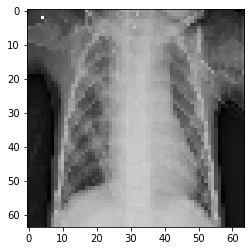

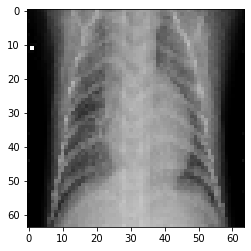

In [3]:
# Plot some images
plt.imshow(train_images[17]/255)
plt.show()

plt.imshow(train_images[4200]/255)
plt.show()

To get a better idea of my data, I also list the shape of both the images and labels for each dataset. As you can see, the images have four dimensions - the first is the number of images, the middle values represent the size of the images, and the fourth value represents the number of channels. 

In [4]:
# Preview the shape of the data
print("Train Data Shape:")
print(np.shape(train_images))
print(np.shape(train_labels))
print("\nTest Data Shape:")
print(np.shape(test_images))
print(np.shape(test_labels))
print("\nValidation Data Shape:")
print(np.shape(val_images))
print(np.shape(val_labels))

Train Data Shape:
(5216, 64, 64, 3)
(5216, 2)

Test Data Shape:
(524, 64, 64, 3)
(524, 2)

Validation Data Shape:
(116, 64, 64, 3)
(116, 2)


I also list the classes I will be working with in this analysis before reshaping the labels. Reshaping the classes now is only meant to examine whether the images truely correspond with their labels. I confirm this with the two following image plots, where the first accurately displays a "normal", or healthy, image, and the second displays an image for a pneumonia-ridden patient. 

In [5]:
# List the classes
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [6]:
# Reshape the labels
y_train_labels = train_labels.T[[1]]
y_test_labels = test_labels.T[[1]]
y_val_labels = val_labels.T[[1]]

# Check the shape of the transformed labels 
print(np.shape(y_train_labels))
print(np.shape(y_test_labels))
print(np.shape(y_val_labels))

(1, 5216)
(1, 524)
(1, 116)


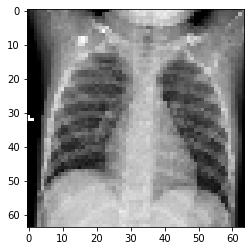

[0.]


In [7]:
# Confirm that the image matches with its corresponding label
plt.imshow(train_images[1400]/255)
plt.show()
print(y_train_labels[:, 1400])

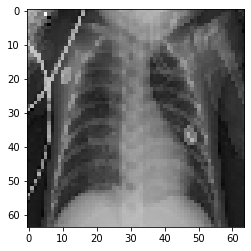

[1.]


In [8]:
# Confirm that the image matches with its corresponding label
plt.imshow(train_images[14]/255)
plt.show()
print(y_train_labels[:, 14])

As you can see, not much data preparation was needed for data understanding. However, there is still need to transform the data to prepare it for modeling, which is the next step.

## Modeling

### Baseline Model:
As I mentioned earlier, the training and validation images will need to be reshaped, along with their labels, so that they contain the same first dimension. In addition, I standardize the images by dividing by 255 (due to the range of pixel intensity values falling between \[0, 255]\.

In [9]:
# Reshape the train, test, and validation images for modeling
X_train = train_images.reshape(5216, -1)
X_test = test_images.reshape(524, -1)
X_val = val_images.reshape(116, -1)

# Preview the shape of each newly-formed objects
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(X_val))

(5216, 12288)
(524, 12288)
(116, 12288)


In [10]:
# Standardize the datasets
X_train_final = X_train/255
X_test_final = X_test/255
X_val_final = X_val/255

In [11]:
# Reshape the labels for modeling
y_train = np.reshape(train_labels[:, 0], (5216, 1))
y_test = np.reshape(test_labels[:, 0], (524, 1))
y_val = np.reshape(val_labels[:, 0], (116, 1))

# Check the shape of the transformed labels 
print(np.shape(y_train))
print(np.shape(y_test))
print(np.shape(y_val))

(5216, 1)
(524, 1)
(116, 1)


Now that the data is fully manipulated, I begin building my baseline neural network by calling the `Sequential` function, then adding two `Dense` hidden layers with ReLu as my activation functions. I also pass in the input shape to create my input layer. The last layer acts as my output layer with a Sigmoid activation function. 

Once constructed, I compile the baseline model, using parameters I established with prior research. As such, `RMSprop` and binary cross-entropy will act as my optimizer and loss functions, respectively. I preview the model summary in order to highlight the number of parameters being trained in each layer, and the shape of the output. 

In [12]:
# Create a dense baseline neural network
baseline_model = Sequential()
baseline_model.add(Dense(32, activation='relu', input_shape=(12288, )))
baseline_model.add(Dense(8, activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))

In [13]:
# Compile the baseline model
baseline_model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['acc'])

# List a summary of the baseline model
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                393248    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 393,521
Trainable params: 393,521
Non-trainable params: 0
_________________________________________________________________


There are 393,521 different parameters being trained in this network, but only 1 value will be output. I fit the model to the training data and labels, while also using the validation data to further validate these results. I also set the number of epochs to 50, with a 64 image batch size.

In [14]:
# Fit the baseline model
baseline = baseline_model.fit(X_train_final, y_train, epochs=50, batch_size=64,
                                      validation_data=(X_val_final, y_val))

Epoch 1/50
82/82 [==============================] - 1s 14ms/step - loss: 0.6555 - acc: 0.7301 - val_loss: 0.8077 - val_acc: 0.8190
Epoch 2/50
82/82 [==============================] - 1s 10ms/step - loss: 0.4309 - acc: 0.7820 - val_loss: 0.5804 - val_acc: 0.6466
Epoch 3/50
82/82 [==============================] - 1s 13ms/step - loss: 0.3198 - acc: 0.8648 - val_loss: 0.9576 - val_acc: 0.5086
Epoch 4/50
82/82 [==============================] - 1s 15ms/step - loss: 0.2699 - acc: 0.8842 - val_loss: 0.3426 - val_acc: 0.8448
Epoch 5/50
82/82 [==============================] - 1s 16ms/step - loss: 0.2372 - acc: 0.9045 - val_loss: 0.5002 - val_acc: 0.6983
Epoch 6/50
82/82 [==============================] - 1s 15ms/step - loss: 0.2366 - acc: 0.8955 - val_loss: 0.6765 - val_acc: 0.5862
Epoch 7/50
82/82 [==============================] - 1s 15ms/step - loss: 0.2060 - acc: 0.9145 - val_loss: 0.3966 - val_acc: 0.7414
Epoch 8/50
82/82 [==============================] - 1s 14ms/step - loss: 0.1890 - a

In [15]:
# Evaluate the loss and accuracy scores for the training and validation datasets
print(f'Training data results:\n{baseline_model.evaluate(X_train_final, y_train)}')
print('\n')
print(f'Validation data results:\n{baseline_model.evaluate(X_val_final, y_val)}')

163/163 [==============================] - 0s 3ms/step - loss: 0.0656 - acc: 0.9755
Training data results:
[0.06561489403247833, 0.9754601120948792]


4/4 [==============================] - 0s 623us/step - loss: 2.2120 - acc: 0.6293
Validation data results:
[2.2120251655578613, 0.6293103694915771]


The baseline results above generated a 97.5% accuracy rate for the training data, but only 62.9% for the validation data, which implies the model is overfitting to the training data. To get a better idea, I create a function that will visualize my training results going forward, and apply it to the baseline model.

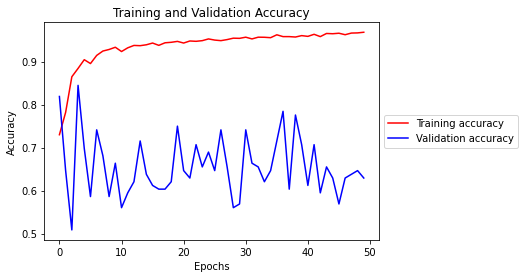

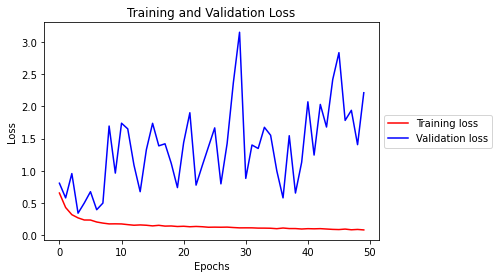

In [16]:
# Create a function that will visualize the training results for both datasets
def visualize_training_results(results):
    acc = results.history['acc']
    val_acc = results.history['val_acc']
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    epochs = range(len(acc))
    
    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

visualize_training_results(baseline)

The visuals above further confirm the overfitting theory. The top graph shows how large a gap the accuracies between both datasets really are, which supports our findings. In order to eliminate the overfitting, I must tune the model.

### Regularizing the Baseline Model:
In order to reduce overfitting to the training data, I apply lasso (L2) regularization, specifically with a penalty of 0.01. The network architecture remains similar to the baseline's framework, with the exception of the L2 regularizer addition in the `kernel_regularizer` parameter. I fit the model with the same number of epochs and batch size, and evaluate the model with the validation data. 

In [17]:
# Regularize the baseline model
regularized_model = Sequential()
regularized_model.add(Dense(32, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(12288, )))
regularized_model.add(Dense(8, activation='relu'))
regularized_model.add(Dense(1, activation = 'sigmoid'))
regularized_model.compile(loss='binary_crossentropy', 
                  optimizer='RMSprop', 
                  metrics=['acc'])
results = regularized_model.fit(X_train_final, y_train, epochs=50, batch_size=64,
                                      validation_data=(X_val_final, y_val))

Epoch 1/50
82/82 [==============================] - 1s 13ms/step - loss: 1.3716 - acc: 0.7019 - val_loss: 1.6100 - val_acc: 0.5000
Epoch 2/50
82/82 [==============================] - 1s 11ms/step - loss: 0.8510 - acc: 0.7391 - val_loss: 0.7771 - val_acc: 0.5690
Epoch 3/50
82/82 [==============================] - 1s 14ms/step - loss: 0.6746 - acc: 0.7640 - val_loss: 0.5303 - val_acc: 0.8190
Epoch 4/50
82/82 [==============================] - 1s 18ms/step - loss: 0.6167 - acc: 0.7724 - val_loss: 1.6144 - val_acc: 0.5000
Epoch 5/50
82/82 [==============================] - 1s 18ms/step - loss: 0.5916 - acc: 0.7960 - val_loss: 1.1698 - val_acc: 0.5086
Epoch 6/50
82/82 [==============================] - 2s 19ms/step - loss: 0.6705 - acc: 0.8190 - val_loss: 0.6405 - val_acc: 0.6897
Epoch 7/50
82/82 [==============================] - 1s 17ms/step - loss: 0.5223 - acc: 0.8301 - val_loss: 1.2949 - val_acc: 0.5086
Epoch 8/50
82/82 [==============================] - 2s 18ms/step - loss: 0.5234 - a

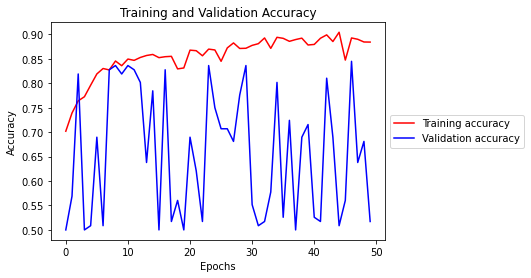

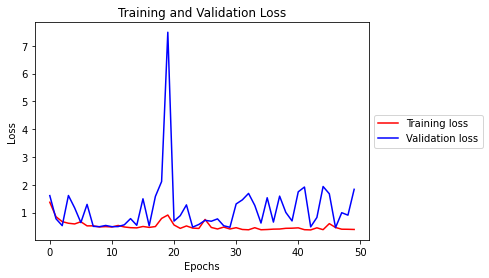

In [18]:
# Visualize the training results
visualize_training_results(results)

### Cross-Validating the Regularized Baseline Model:

In [19]:
# Create a function that will build the regularized model above
def build_reg_model():
    regularized_model = Sequential()
    regularized_model.add(Dense(32, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(12288, )))
    regularized_model.add(Dense(8, activation='relu'))
    regularized_model.add(Dense(1, activation = 'sigmoid'))
    regularized_model.compile(loss='binary_crossentropy', 
                  optimizer='RMSprop', 
                  metrics=['acc'])
    return regularized_model

In [20]:
# Cross-validate using various scikit-learn tools
keras_model = scikit_learn.KerasClassifier(build_reg_model,
                                          epochs=32,
                                          batch_size=64,
                                          verbose=2)
kfold = KFold(shuffle=True, random_state=seed)
validation_scores = cross_val_score(keras_model, X_train_final, y_train, cv=kfold)

Epoch 1/32
66/66 - 1s - loss: 1.2164 - acc: 0.7157
Epoch 2/32
66/66 - 1s - loss: 0.8352 - acc: 0.7256
Epoch 3/32
66/66 - 1s - loss: 1.0919 - acc: 0.6719
Epoch 4/32
66/66 - 1s - loss: 0.7630 - acc: 0.7260
Epoch 5/32
66/66 - 1s - loss: 0.5960 - acc: 0.7680
Epoch 6/32
66/66 - 1s - loss: 0.6355 - acc: 0.7536
Epoch 7/32
66/66 - 1s - loss: 0.6690 - acc: 0.7488
Epoch 8/32
66/66 - 1s - loss: 0.7438 - acc: 0.7430
Epoch 9/32
66/66 - 1s - loss: 0.6689 - acc: 0.7315
Epoch 10/32
66/66 - 1s - loss: 0.7157 - acc: 0.7373
Epoch 11/32
66/66 - 1s - loss: 0.8086 - acc: 0.7244
Epoch 12/32
66/66 - 1s - loss: 0.5681 - acc: 0.7685
Epoch 13/32
66/66 - 1s - loss: 0.5441 - acc: 0.7891
Epoch 14/32
66/66 - 1s - loss: 0.6895 - acc: 0.7680
Epoch 15/32
66/66 - 1s - loss: 0.4951 - acc: 0.8219
Epoch 16/32
66/66 - 1s - loss: 0.6763 - acc: 0.7999
Epoch 17/32
66/66 - 1s - loss: 0.6429 - acc: 0.8001
Epoch 18/32
66/66 - 1s - loss: 0.7138 - acc: 0.7872
Epoch 19/32
66/66 - 1s - loss: 0.6381 - acc: 0.8164
Epoch 20/32
66/66 - 1

Epoch 29/32
66/66 - 1s - loss: 0.5397 - acc: 0.8220
Epoch 30/32
66/66 - 1s - loss: 0.5473 - acc: 0.8167
Epoch 31/32
66/66 - 1s - loss: 0.5505 - acc: 0.8289
Epoch 32/32
66/66 - 1s - loss: 0.5089 - acc: 0.8085
17/17 - 0s - loss: 0.3573 - acc: 0.9396


In [21]:
# Calculate the training data's average validation score
validation_scores.mean()

0.8493303298950196

## Further Modeling
### Convolutional Neural Network (CNN):

In [22]:
# Construct the CNN model's framework
CNNmodel = Sequential()
CNNmodel.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
CNNmodel.add(MaxPooling2D((2, 2)))

CNNmodel.add(Conv2D(32, (4, 4), activation='relu'))
CNNmodel.add(MaxPooling2D((2, 2)))

CNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(MaxPooling2D((2, 2)))

CNNmodel.add(Flatten())
CNNmodel.add(Dense(64, activation='relu'))
CNNmodel.add(Dense(1, activation='sigmoid'))

CNNmodel.compile(loss='binary_crossentropy',
              optimizer="RMSprop",
              metrics=['acc'])

In [23]:
# Fit the CNN model
CNNresults = CNNmodel.fit(train_images,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_images, y_val))

Epoch 1/50
163/163 [==============================] - 28s 173ms/step - loss: 2.6511 - acc: 0.7368 - val_loss: 0.6047 - val_acc: 0.6638
Epoch 2/50
163/163 [==============================] - 30s 186ms/step - loss: 0.3509 - acc: 0.8758 - val_loss: 2.7468 - val_acc: 0.5690
Epoch 3/50
163/163 [==============================] - 31s 188ms/step - loss: 0.2599 - acc: 0.9256 - val_loss: 3.2729 - val_acc: 0.5948
Epoch 4/50
163/163 [==============================] - ETA: 0s - loss: 0.1760 - acc: 0.944 - 29s 178ms/step - loss: 0.1760 - acc: 0.9446 - val_loss: 2.0842 - val_acc: 0.6207
Epoch 5/50
163/163 [==============================] - 29s 177ms/step - loss: 0.1400 - acc: 0.9574 - val_loss: 1.6641 - val_acc: 0.6897
Epoch 6/50
163/163 [==============================] - 30s 181ms/step - loss: 0.1157 - acc: 0.9597 - val_loss: 1.1319 - val_acc: 0.6638
Epoch 7/50
163/163 [==============================] - 34s 206ms/step - loss: 0.1121 - acc: 0.9684 - val_loss: 2.3688 - val_acc: 0.6121
Epoch 8/50
163/16

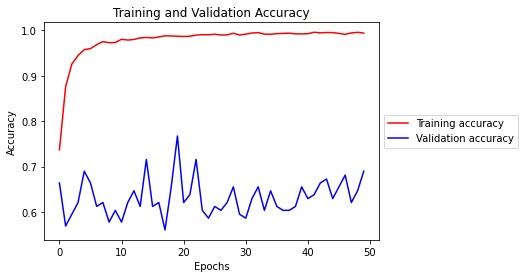

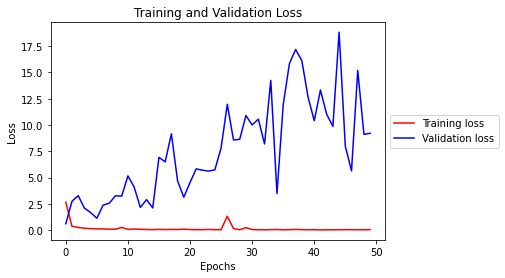

In [24]:
# Visualize the training results
visualize_training_results(CNNresults)

### Data Augmentation

In [25]:
# Reshape the training data for augmentation 
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=15, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   brightness_range=[1, 1.5], 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

In [26]:
# Get all the data in the training directory (in batches) and standardize
train_generator_aug = train_datagen.flow_from_directory(
    train_data_dir, target_size=(64, 64), 
    batch_size=32, seed=seed, class_mode='binary')

# Get all the data in the test directory and standardize
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_data_dir, target_size=(64, 64), 
    batch_size = 524, seed=seed, class_mode='binary') 

# Get all the data in the validation directory (in batches) and standardize
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validation_dir, target_size=(64, 64),
    batch_size = 32, seed=seed, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


In [27]:
# Build a CNN model framework using the augmented training data
augCNNmodel = Sequential()
augCNNmodel.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
augCNNmodel.add(MaxPooling2D((2, 2)))

augCNNmodel.add(Conv2D(32, (4, 4), activation='relu'))
augCNNmodel.add(MaxPooling2D((2, 2)))

augCNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
augCNNmodel.add(MaxPooling2D((2, 2)))

augCNNmodel.add(Flatten())
augCNNmodel.add(Dense(64, activation='relu'))
augCNNmodel.add(Dense(1, activation='sigmoid'))

augCNNmodel.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [28]:
#Create a file name object for the best model checkpoint
model_filepath = 'best_aug_model.h5'

# Set early stopping and model checkpoint parameters
early_stopping = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True)]

In [29]:
# Fit the augmented CNN model
augCNNresults = augCNNmodel.fit(train_generator_aug,
                                epochs=32,
                                callbacks=early_stopping,
                                validation_data=val_generator)

Epoch 1/32
163/163 [==============================] - 128s 787ms/step - loss: 0.5489 - acc: 0.7412 - val_loss: 0.8534 - val_acc: 0.5000
Epoch 2/32
163/163 [==============================] - 126s 772ms/step - loss: 0.4804 - acc: 0.7577 - val_loss: 0.6321 - val_acc: 0.6293
Epoch 3/32
163/163 [==============================] - 135s 829ms/step - loss: 0.4408 - acc: 0.7816 - val_loss: 0.5561 - val_acc: 0.7586
Epoch 4/32
163/163 [==============================] - 140s 858ms/step - loss: 0.4231 - acc: 0.7912 - val_loss: 0.5302 - val_acc: 0.7586
Epoch 5/32
163/163 [==============================] - 128s 786ms/step - loss: 0.3953 - acc: 0.8138 - val_loss: 0.5906 - val_acc: 0.6379
Epoch 6/32
163/163 [==============================] - 93s 569ms/step - loss: 0.3733 - acc: 0.8259 - val_loss: 0.4886 - val_acc: 0.7845
Epoch 7/32
163/163 [==============================] - 79s 486ms/step - loss: 0.3615 - acc: 0.8322 - val_loss: 0.4761 - val_acc: 0.8103
Epoch 8/32
163/163 [==============================

In [30]:
# Load the best (saved) model for the augmented data
saved_model = load_model(model_filepath)

# Calculate the loss and accuracy scores for both training datasets
results_train = saved_model.evaluate(train_generator_aug)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_val = saved_model.evaluate(val_generator)
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

163/163 [==============================] - 86s 526ms/step - loss: 0.3082 - acc: 0.8643
Training Loss: 0.308 
Training Accuracy: 0.864
----------
4/4 [==============================] - 1s 255ms/step - loss: 0.4172 - acc: 0.8276
Validation Loss: 0.417 
Validation Accuracy: 0.828


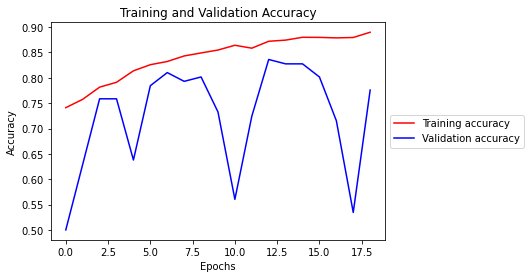

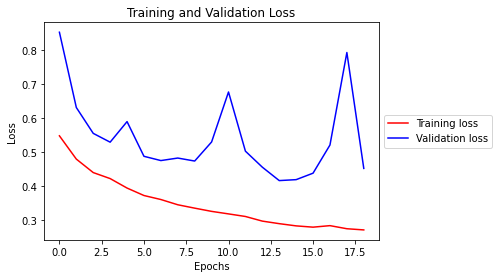

In [31]:
# Plot the training results
visualize_training_results(augCNNresults)

### Transfer Learning Approach:

In [32]:
# Instantiate the CNN base object
cnn_base = ResNet50(weights='imagenet', 
                 include_top=False, 
                 input_shape=(64, 64, 3))

# Preview the various parameters that will be trained
cnn_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [33]:
# Build a network with the CNN base
resnet_model = Sequential()
resnet_model.add(cnn_base)
resnet_model.add(Flatten())
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

# Freeze the base model
cnn_base.trainable = False

# List all the trainable layers
for layer in resnet_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, check how many trainable weights are in the model 
print(f'Trainable weights: {len(resnet_model.trainable_weights)}\n')

# Preview the various parameters and output shapes, once again
resnet_model.summary()

resnet50 False
flatten_2 True
dense_25 True
dense_26 True
Trainable weights: 4

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 25,685,377
Trainable params: 2,097,665
Non-trainable params: 23,587,712
_________________________________________________________________


In [34]:
# Compile the transfer learning model
resnet_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=.001),
              metrics=['acc'])

# Fit the model
resnet_results = resnet_model.fit(train_generator_aug,
                              epochs=10,
                              validation_data=val_generator)

Epoch 1/10
163/163 [==============================] - 122s 745ms/step - loss: 0.5235 - acc: 0.7604 - val_loss: 0.5701 - val_acc: 0.6207
Epoch 2/10
163/163 [==============================] - 116s 713ms/step - loss: 0.4421 - acc: 0.8012 - val_loss: 0.8185 - val_acc: 0.5517
Epoch 3/10
163/163 [==============================] - 115s 703ms/step - loss: 0.4233 - acc: 0.8000 - val_loss: 0.4498 - val_acc: 0.8190
Epoch 4/10
163/163 [==============================] - 120s 734ms/step - loss: 0.4130 - acc: 0.8052 - val_loss: 0.4384 - val_acc: 0.8190
Epoch 5/10
163/163 [==============================] - 118s 721ms/step - loss: 0.4146 - acc: 0.8117 - val_loss: 0.6043 - val_acc: 0.6466
Epoch 6/10
163/163 [==============================] - 117s 721ms/step - loss: 0.4091 - acc: 0.8115 - val_loss: 0.7513 - val_acc: 0.5603
Epoch 7/10
163/163 [==============================] - 118s 725ms/step - loss: 0.3967 - acc: 0.8177 - val_loss: 0.4699 - val_acc: 0.7500
Epoch 8/10
163/163 [============================

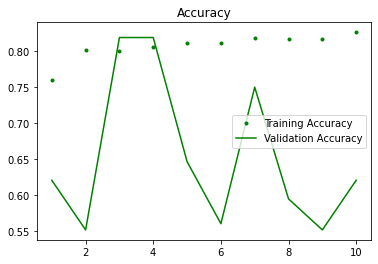

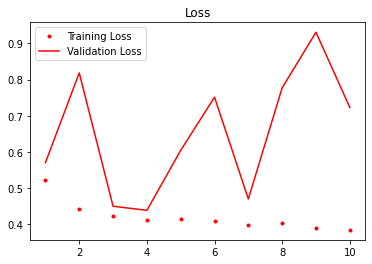

In [35]:
# Plot the training results using different markers
resnet_train_acc = resnet_results.history['acc']
resnet_val_acc = resnet_results.history['val_acc']
resnet_train_loss = resnet_results.history['loss']
resnet_val_loss = resnet_results.history['val_loss']
epch = range(1, len(resnet_train_acc) + 1)

plt.plot(epch, resnet_train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, resnet_val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, resnet_train_loss, 'r.', label='Training Loss')
plt.plot(epch, resnet_val_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Deployment & Evaluation

In [42]:
# Evaluate the test data and list testing accuracy
test_loss, test_acc = saved_model.evaluate(test_generator)
y_hat_test = saved_model.predict(test_generator)
print('Generated {} predictions'.format(len(y_hat_test)))
print('test acc:', test_acc)

1/1 [==============================] - 0s 8ms/step - loss: 0.3982 - acc: 0.8225
Generated 524 predictions
test acc: 0.822519063949585


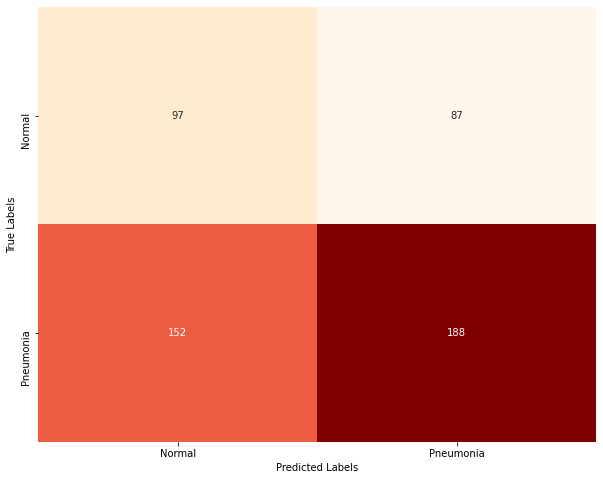

In [50]:
y_test = test_generator.classes
y_hat_test[y_hat_test > 0.5] = 1
y_hat_test[y_hat_test < 0.5] = 0
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True,
           fmt='.3g', xticklabels=['Normal', 'Pneumonia'],
           yticklabels=['Normal', 'Pneumonia'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Conclusion

## Limitations & Further Work